<h1 style="text-align: center;">Min-Variance Portfolio</h1>

# 1. Pre-requisities

## 1.1 Librairies

In [1]:
import os
import warnings
import numpy as np
import pandas as pd

# For PCA
import statsmodels.api as sm
from statsmodels.multivariate import pca
from ppca import PPCA

#For portfolio optimization
from scipy.optimize import minimize
import cvxpy as cp

# For plotting and formatting the plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtkr
import matplotlib.dates as mdts
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode()

## 1.2 Path

In [2]:
path = "/Users/hroccaro/Desktop/minvarportfolio"
os.chdir(path)

## 1.3 Useful Functions

In [3]:
# Funtion to make a time series plot on one axis

def plot_timeseries_one_axis(data, y_label=None):
    """
    Plot a time series graph using a single axis.

    Args
    ----
    data : pandas DataFrame
        A DataFrame with the time series data to be plotted. Dates should be set as the index.
    y_label : str, optional
        The label for the y-axis. If None, no label is set. Default is None.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The `Figure` object which acts as the container for the plot. It can be used for further customizations or saving the plot.    
    ax : matplotlib.axes.Axes
        The `Axes` object representing the plot of the time series. It provides access to axes-level functions for further customization.
    """

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    data.plot(ax=ax, lw=1.)
    if y_label is not None:
        ax.set_ylabel(ylabel=y_label)
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%b-%y'))
    ax.legend(loc='best', framealpha=0)

    return fig, ax

In [4]:
# Function to make a correlation heatmap

def plot_heatmap(data_df, ax=None, cbar_kw=None, cbarlabel="Correlation", annotate=True, **kwargs):
    """
    Create and annotate a heatmap from a pandas DataFrame.

    Args
    ----
    data_df : pandas DataFrame
        A DataFrame with the data to be plotted. Row and column labels are taken from the DataFrame.
    ax : matplotlib.axes.Axes, optional
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.
    cbar_kw : dict, optional
        A dictionary with arguments to `matplotlib.Figure.colorbar`.
    cbarlabel : str, optional
        The label for the colorbar.
    annotate : bool, optional
        Flag to annotate the heatmap. Default is True.
    **kwargs
        All other arguments are forwarded to `imshow`.
            
    Returns
    -------
    im : matplotlib.image.AxesImage
        The `AxesImage` object created by `imshow` representing the heatmap. It can be used for further customizations if needed.
    cbar : matplotlib.colorbar.Colorbar
        The `Colorbar` object for the heatmap. It represents the color scale of the heatmap and is attached to the provided axes. This can also be used for further customizations, like changing the colorbar properties.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Extract data and labels from the DataFrame
    data = data_df.values
    row_labels = data_df.index
    col_labels = data_df.columns

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, shrink=0.8, format=mtkr.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotate the heatmap
    if annotate:
        # Normalizing the threshold
        threshold = im.norm(data.max())/2.

        # Setting up the format for annotations
        valfmt = mtkr.FuncFormatter(lambda x, _: '{:.0%}'.format(x))

        # Loop over the data and create a `Text` for each "pixel".
        textcolors = ("black", "white")
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                color = textcolors[int(im.norm(data[i, j]) > threshold)]
                im.axes.text(j, i, valfmt(data[i, j], None),
                             ha="center", va="center", color=color)

    return im, cbar

In [5]:
# Function for computing portfolio return

def portfolio_returns(daily_returns, weights):
    """
    Calculate the annualized return of a portfolio based on daily returns and portfolio weights.

    Args
    ----
    daily_returns : pandas DataFrame or array_like
        The daily returns of the assets in the portfolio. Each column should represent an asset.
    weights : array_like
        Weights of the assets in the portfolio. The sum of all weights should be 1.

    Returns
    -------
    returns : float
        The annualized return of the portfolio. This is computed as the sum of the mean of daily returns 
        of each asset, weighted by the portfolio weights, and then annualized (typically using 253 trading days).
    """

    returns = (np.sum(daily_returns.mean() * weights)) * 253
    
    return returns

In [6]:
# Function for computing standard deviation of portfolio returns

def portfolio_sd(daily_returns, weights):
    """
    Calculate the standard deviation of annualized returns of a portfolio, representing the portfolio risk.

    Args
    ----
    daily_returns : pandas DataFrame or array_like
        The daily returns of the assets in the portfolio. Each column should represent an asset.
    weights : array_like
        Weights of the assets in the portfolio. The sum of all weights should be 1.

    Returns
    -------
    sd : float
        The standard deviation of the portfolio's annualized returns, which represents the portfolio risk.
        Calculated using the covariance matrix of the daily returns, weighted by the portfolio weights,
        and annualized (typically using 253 trading days).
    """

    sd = np.sqrt(np.dot(np.transpose(weights), np.dot(daily_returns.cov() * 253, weights)))
    
    return sd

# 2. PCA

## 2.1 Data Preproccesing

In [7]:
# Read Data

change_freq = '4w'
data_pca = pd.read_csv(filepath_or_buffer='_'.join(['Multi-asset PCA', 'CHANGES=' + change_freq]) + '.csv',
                      index_col=0, header=0,
                      parse_dates=True).astype(np.float64)

n_assets = data_pca.shape[1]

In [8]:
# Show the dateframe
data_pca

MSCI World   S&P 500  Euro Stoxx 50  Euro Stoxx Banks  CDX.IG 5Y  \
2005-06-10    0.012532  0.022793       0.056718          0.047424   0.006602   
2005-07-06    0.002255 -0.002649       0.025209          0.017424  -0.000800   
2005-08-03    0.046502  0.041080       0.036400          0.041141   0.003598   
2005-08-31   -0.008268 -0.020054      -0.024171         -0.019341   0.001110   
2005-09-27    0.010540 -0.003834       0.036243          0.042163   0.000609   
...                ...       ...            ...               ...        ...   
2022-11-30    0.084752  0.081787       0.090406          0.073881   0.007581   
2022-12-28   -0.055047 -0.075548      -0.040116          0.012875  -0.003171   
2023-01-25    0.068134  0.059766       0.085333          0.101296   0.006157   
2023-02-22   -0.009421 -0.006287       0.022589          0.063275  -0.001573   
2023-03-22   -0.016522 -0.013643      -0.011182         -0.096528  -0.000676   

            CDX.HY 5Y  iTraxx Europe 5Y  iTraxx Crossover 5Y  \
2005-06-10   0.026766          0.006048             0.035003   
2005-07-06   0.006752          0.001608             0.012723   
2005-08-03   0.018337          0.001442             0.003727   
2005-08-31  -0.003190          0.000003             0.002291   
2005-09-27  -0.001547          0.001839             0.008034   
...               ...               ...                  ...   
2022-11-30   0.030603          0.009734             0.036006   
2022-12-28  -0.014656          0.000119            -0.004665   
2023-01-25   0.028027          0.006219             0.024940   
2023-02-22  -0.007013          0.000186             0.003366   
2023-03-22  -0.013304         -0.000156            -0.002206   

            Italy - Germany 10Y  US 2Y  ...  USD 3M x 10Y ATM vol.  \
2005-06-10                  4.9   1.65  ...                   0.00   
2005-07-06                  0.9   7.43  ...                   0.95   
2005-08-03                 -2.9  24.17  ...                   0.15   
2005-08-31                  1.6 -19.54  ...                  -2.95   
2005-09-27                 -0.1  25.54  ...                  -0.05   
...                         ...    ...  ...                    ...   
2022-11-30                -20.9 -30.95  ...                 -14.10   
2022-12-28                 17.9   4.10  ...                   4.60   
2023-01-25                -33.4 -22.62  ...                 -17.90   
2023-02-22                 15.3  56.83  ...                   2.40   
2023-03-22                 -9.9 -75.66  ...                   9.20   

            USD 1Y x 10Y ATM vol.  USD 5Y x 5Y ATM vol.  \
2005-06-10                 -0.400                  2.65   
2005-07-06                  0.950                 -2.10   
2005-08-03                 -1.150                 -2.55   
2005-08-31                  0.600                  1.95   
2005-09-27                 -0.750                 -0.70   
...                           ...                   ...   
2022-11-30                 -4.654                 -2.90   
2022-12-28                  3.006                  2.50   
2023-01-25                -21.406                -14.50   
2023-02-22                  3.907                  4.30   
2023-03-22                  1.447                  2.70   

            USD 10Y x 20Y ATM vol.  US Govt.  European Govt.  US Corp. Bonds  \
2005-06-10                   -0.15  0.010386        0.017674        0.013421   
2005-07-06                   -1.80  0.001192       -0.004078        0.002829   
2005-08-03                   -2.20 -0.008140       -0.005336       -0.004783   
2005-08-31                    2.75  0.016193        0.015940        0.016234   
2005-09-27                    0.35 -0.011720        0.000517       -0.014359   
...                            ...       ...             ...             ...   
2022-11-30                   -2.30  0.026953        0.022098        0.047535   
2022-12-28                    2.00 -0.006943       -0.045961       -0.006454   
2023-01-25  

In [9]:
# Normalise the data to have zero mean and standard deviation 1; show the normalised data

data_pca_normalised = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_normalised

MSCI World   S&P 500  Euro Stoxx 50  Euro Stoxx Banks  CDX.IG 5Y  \
2005-06-10    0.167450  0.343277       1.016358          0.552594   1.021668   
2005-07-06   -0.027851 -0.153893       0.436512          0.233379  -0.263237   
2005-08-03    0.812959  0.700608       0.642461          0.485735   0.500203   
2005-08-31   -0.227815 -0.494001      -0.472199         -0.157813   0.068151   
2005-09-27    0.129590 -0.177045       0.639576          0.496616  -0.018805   
...                ...       ...            ...               ...        ...   
2022-11-30    1.539804  1.496070       1.636306          0.834108   1.191457   
2022-12-28   -1.116731 -1.578400      -0.765623          0.184979  -0.674976   
2023-01-25    1.224006  1.065746       1.542955          1.125815   0.944331   
2023-02-22   -0.249724 -0.224972       0.388311          0.721253  -0.397561   
2023-03-22   -0.384663 -0.368717      -0.233170         -0.979117  -0.241827   

            CDX.HY 5Y  iTraxx Europe 5Y  iTraxx Crossover 5Y  \
2005-06-10   0.940069          0.834451             1.310608   
2005-07-06   0.130086          0.121136             0.364581   
2005-08-03   0.598946          0.094529            -0.017407   
2005-08-31  -0.272288         -0.136733            -0.078345   
2005-09-27  -0.205800          0.158257             0.165498   
...               ...               ...                  ...   
2022-11-30   1.095391          1.426497             1.353180   
2022-12-28  -0.736341         -0.118090            -0.373734   
2023-01-25   0.991104          0.861899             0.883335   
2023-02-22  -0.426986         -0.107307            -0.032696   
2023-03-22  -0.681624         -0.162214            -0.269298   

            Italy - Germany 10Y     US 2Y  ...  USD 3M x 10Y ATM vol.  \
2005-06-10             0.148132  0.072246  ...              -0.012515   
2005-07-06             0.006282  0.343949  ...               0.066179   
2005-08-03            -0.128475  1.130855  ...              -0.000089   
2005-08-31             0.031106 -0.923843  ...              -0.256881   
2005-09-27            -0.029180  1.195255  ...              -0.016656   
...                         ...       ...  ...                    ...   
2022-11-30            -0.766798 -1.460199  ...              -1.180501   
2022-12-28             0.609143  0.187414  ...               0.368531   
2023-01-25            -1.210078 -1.068626  ...              -1.495278   
2023-02-22             0.516941  2.666119  ...               0.186292   
2023-03-22            -0.376711 -3.561904  ...               0.749576   

            USD 1Y x 10Y ATM vol.  USD 5Y x 5Y ATM vol.  \
2005-06-10              -0.059194              0.499113   
2005-07-06               0.112389             -0.404934   
2005-08-03              -0.154518             -0.490581   
2005-08-31               0.067905              0.365885   
2005-09-27              -0.103678             -0.138478   
...                           ...                   ...   
2022-11-30              -0.599871             -0.557195   
2022-12-28               0.373703              0.470564   
2023-01-25              -2.729024             -2.764973   
2023-02-22               0.488219              0.813150   
2023-03-22               0.175557              0.508629   

            USD 10Y x 20Y ATM vol.  US Govt.  European Govt.  US Corp. Bonds  \
2005-06-10               -0.047339  0.637123        1.088591        0.489450   
2005-07-06               -0.546551 -0.067827       -0.391676       -0.009991   
2005-08-03               -0.667572 -0.783406       -0.477266       -0.368965   
2005-08-31                0.830064  1.082408        0.970536        0.622093   
2005-09-27                0.103937 -1.057891       -0.078988       -0.820468   
...                            ...       ...             ...             ...   
2022-11-30               -0.697827  1.907484        1.389646        2.098054   
2022-12-28                0.603149 -0.691614       -3.24

In [10]:
# Show correlation data

data_pca_corr = data_pca_normalised.corr()
data_pca_corr.style.format(formatter='{:.0%}')

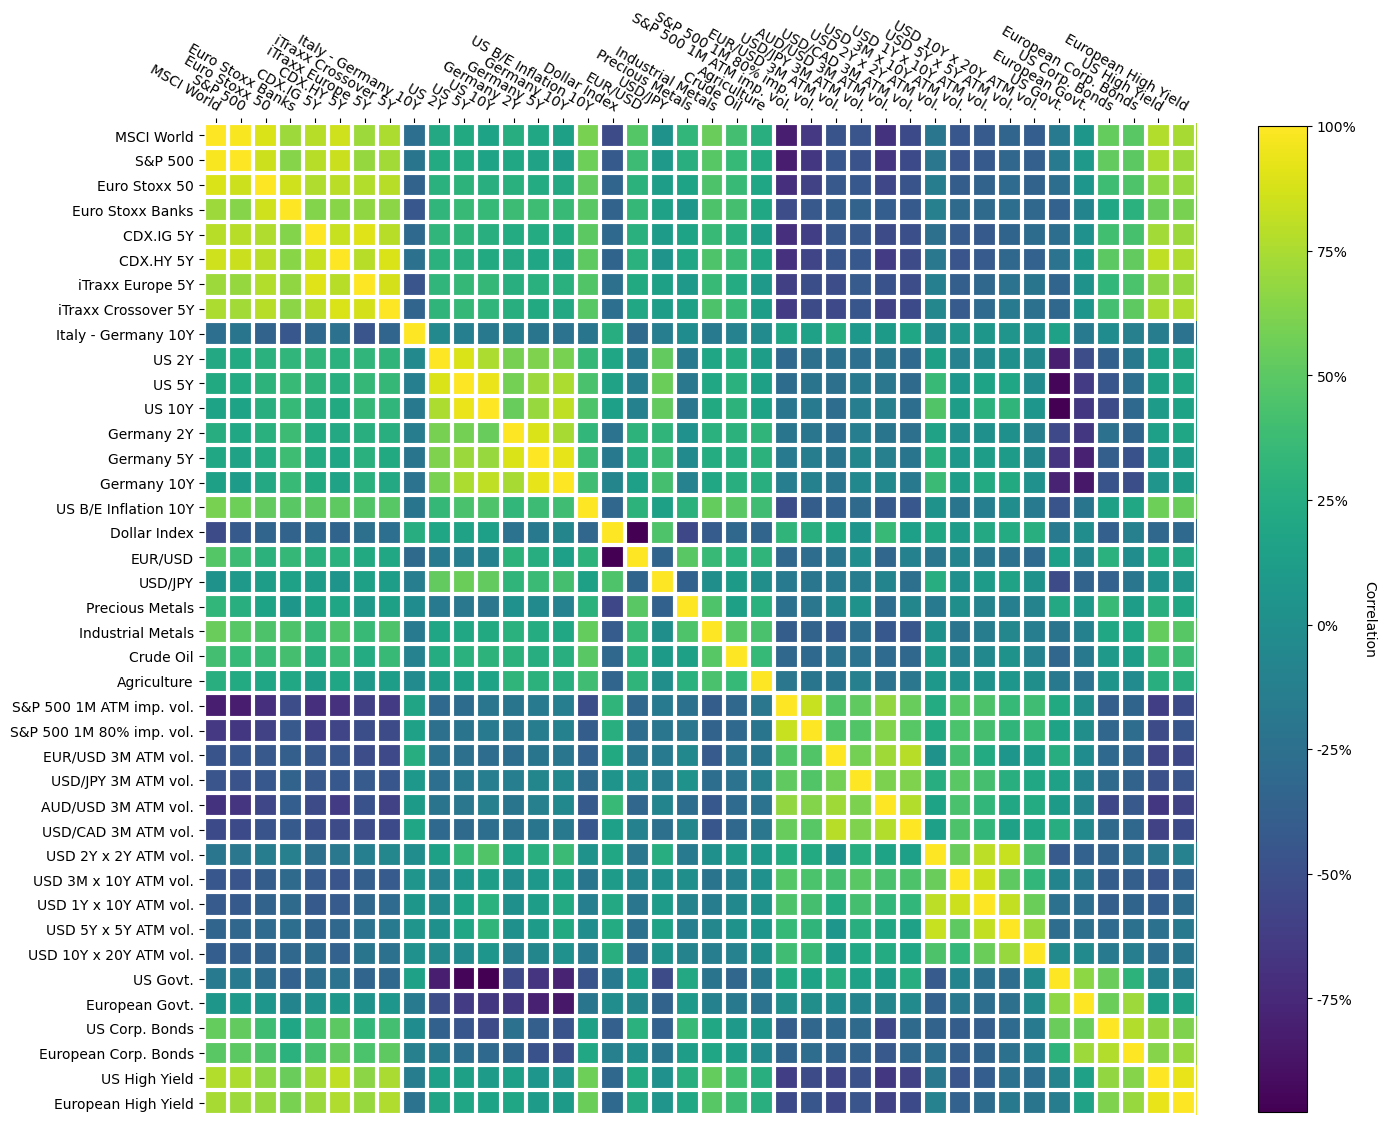

In [11]:
# Display the correlation heatmap

plt.figure(figsize=(16, 16))
plot_heatmap(data_pca_corr, annotate=False);

## 2.2 Analysis

In [12]:
# Perform PCA; obtain the loading matrix, scores, and explained variance

pca_model = pca.PCA(data=data_pca_normalised.values, standardize=True, normalize=False)
loadings = pca_model.loadings
scores = pca_model.scores
explained_variance = pca_model.eigenvals
explained_variance_ratio = explained_variance / explained_variance.sum() * 100
cumulative_explained_variance_ratio = pca_model.rsquare * 100

In [13]:
# Convert the numpy array loadings and scores to a pandas DataFrame for ease of viewing

scores_df = pd.DataFrame(
    index=data_pca_normalised.index,
    columns=[''.join(['PC', str(i + 1)]) for i in range(n_assets)],
    data=scores)

loadings_df = pd.DataFrame(
    index=data_pca_normalised.columns,
    columns=[''.join(['PC', str(j + 1)]) for j in range(n_assets)],
    data=loadings)

loadings_df.iloc[:, :6].style.format(formatter='{:+.2f}').map(func=lambda x: 'color:red' if x < 0. else 'color:blue')

In [14]:
# Creating a pandas DataFrame for easy visualization of explained variance
var_explained_df = pd.DataFrame(
    {
        "Dim": [x for x in range(len(explained_variance) + 1)],
        "% var. explained": np.insert(explained_variance_ratio, 0, 0),
        "% cum. var. explained": cumulative_explained_variance_ratio
    }
).set_index('Dim')
var_explained_df

% var. explained  % cum. var. explained
Dim                                         
0            0.000000               0.000000
1           34.950111              34.950111
2           19.612252              54.562363
3            7.861521              62.423884
4            6.735117              69.159001
5            4.431694              73.590695
6            3.200052              76.790747
7            2.573463              79.364210
8            2.358504              81.722714
9            1.910359              83.633073
10           1.750775              85.383848
11           1.631243              87.015092
12           1.431360              88.446452
13           1.307656              89.754108
14           1.282720              91.036828
15           1.145210              92.182038
16           1.060773              93.242811
17           0.900256              94.143067
18           0.781254              94.924322
19           0.754358              95.678680
20           0.657798              96.336478
21           0.631121              96.967599
22           0.457441              97.425039
23           0.391695              97.816735
24           0.321597              98.138332
25           0.290392              98.428724
26           0.264747              98.693471
27           0.228898              98.922369
28           0.209170              99.131539
29           0.162305              99.293845
30           0.143251              99.437096
31           0.128480              99.565576
32           0.097474              99.663050
33           0.093696              99.756746
34           0.060678              99.817424
35           0.057775              99.875199
36           0.041031              99.916229
37           0.034187              99.950416
38           0.020866              99.971283
39           0.017745              99.989028
40           0.010972             100.000000

In [15]:
# Find the first dimension where % cum. var. explained exceeds 75%
dim_75 = var_explained_df[var_explained_df['% cum. var. explained'] >= 75].index[0]

# Find the first dimension where % cum. var. explained exceeds 80%
dim_80 = var_explained_df[var_explained_df['% cum. var. explained'] >= 80].index[0]

point_index_75 = next(i for i, y in enumerate(var_explained_df['% cum. var. explained']) if 75 <= y)
point_index_80 = next(i for i, y in enumerate(var_explained_df['% cum. var. explained']) if 80 <= y)

Text(0, 0.5, 'Cumulative Explained Variance')

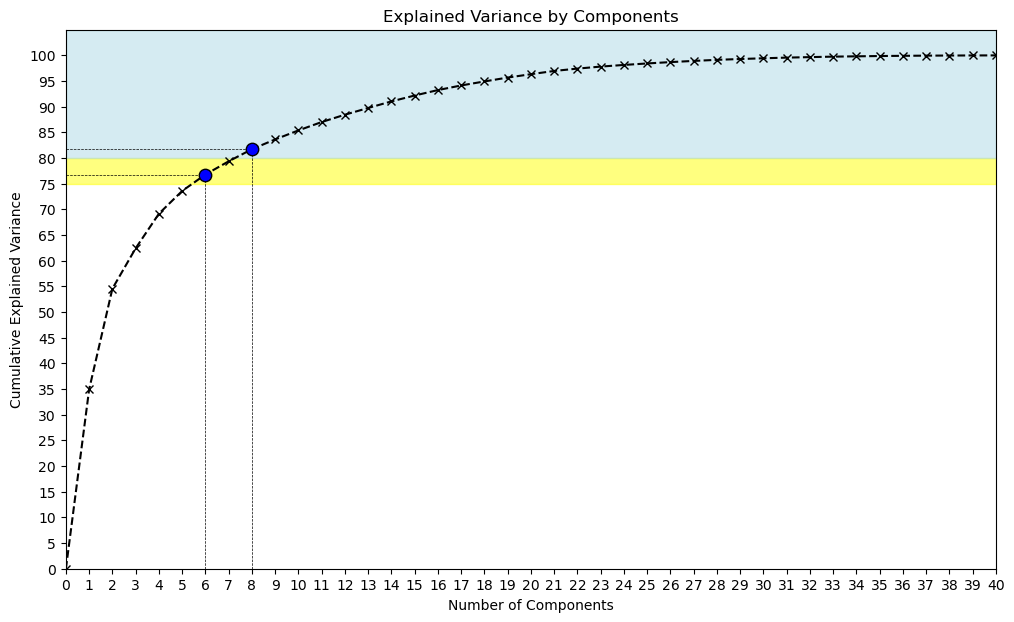

In [16]:
plt.figure(figsize=(12,7))
plt.plot(range(len(explained_variance) + 1), var_explained_df['% cum. var. explained'], marker = 'x', linestyle = '--', color ='black')

plt.fill_between(range(len(explained_variance) + 1), 75, 80, color='yellow', alpha=0.5)
plt.fill_between(range(len(explained_variance) + 1), 80, var_explained_df['% cum. var. explained'].max()+5, color='lightblue', alpha=0.5)

point_index_75 = next(i for i, y in enumerate(var_explained_df['% cum. var. explained']) if 75 <= y)
point_index_80 = next(i for i, y in enumerate(var_explained_df['% cum. var. explained']) if 80 <= y)


plt.scatter(point_index_75, var_explained_df['% cum. var. explained'][point_index_75], color='blue', edgecolor='black', zorder=5, s=80)
plt.scatter(point_index_80, var_explained_df['% cum. var. explained'][point_index_80], color='blue', edgecolor='black', zorder=5, s=80)

plt.hlines(y=var_explained_df['% cum. var. explained'][point_index_75], xmin=0, xmax=dim_75, colors='black', linestyles='dashed', linewidth=0.5, label='75% Variance Explained')
plt.vlines(x=dim_75, ymin=0, ymax=var_explained_df['% cum. var. explained'][point_index_75], colors='black', linestyles='dashed', linewidth=0.5)
plt.hlines(y=var_explained_df['% cum. var. explained'][point_index_80], xmin=0, xmax=dim_80, colors='black', linestyles='dashed', linewidth=0.5, label='80% Variance Explained')
plt.vlines(x=dim_80, ymin=0, ymax=var_explained_df['% cum. var. explained'][point_index_80], colors='black', linestyles='dashed', linewidth=0.5)

plt.ylim(0, 105)
plt.xlim(0, len(explained_variance))
plt.yticks(np.arange(0, 105, 5))
plt.xticks(np.arange(0, len(explained_variance) + 1, 1))

plt.title("Explained Variance by Components")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [17]:
# Display the results
print(f"The number of components needed to explain 75% of the variance is: {dim_75}\n"
      f"The number of components needed to explain 80% of the variance is: {dim_80}")

The number of components needed to explain 75% of the variance is: 6
The number of components needed to explain 80% of the variance is: 8


In [18]:
rsquare_df = pd.DataFrame(index=data_pca_normalised.columns, columns=['PC' + str(i) for i in range(1, 7)])

for factor in data_pca_normalised.columns:
    for i in range(6):
        model = sm.OLS(data_pca_normalised[factor], sm.add_constant(scores_df.iloc[:, i])).fit()
        rsquare_df.at[factor, 'PC' + str(i + 1)] = model.rsquared

# Display R² Dataframe
rsquare_df

PC1       PC2       PC3       PC4       PC5  \
MSCI World                0.847734  0.018132  0.015373  0.001434  0.011094   
S&P 500                   0.791634  0.019967   0.00022  0.001818  0.007687   
Euro Stoxx 50             0.747764  0.000497  0.001075  0.001861  0.088351   
Euro Stoxx Banks          0.574965  0.017899  0.002831  0.002532  0.120362   
CDX.IG 5Y                 0.719317  0.001376  0.011846   0.00001  0.075298   
CDX.HY 5Y                 0.779932  0.009609  0.004181  0.007669  0.035685   
iTraxx Europe 5Y           0.66557  0.001616  0.022407  0.010025  0.130195   
iTraxx Crossover 5Y       0.726087  0.000088  0.016429  0.041374  0.047959   
Italy - Germany 10Y        0.10482  0.006027  0.007327  0.004699  0.221695   
US 2Y                     0.147492  0.480846  0.083955  0.033085  0.003437   
US 5Y                     0.142163  0.702009  0.042211  0.001648  0.000329   
US 10Y                    0.108046  0.772846  0.017462  0.004516  0.002325   
Germany 2Y                0.144694  0.405909  0.062542  0.074811  0.004935   
Germany 5Y                0.109984  0.623796  0.060162  0.066282  0.000839   
Germany 10Y               0.082478  0.743492  0.028793  0.021847  0.003587   
US B/E Inflation 10Y      0.444796  0.060727  0.040191   0.01617  0.006221   
Dollar Index              0.192258   0.05414  0.613654  0.013217  0.002187   
EUR/USD                   0.161131  0.023387  0.614468  0.040719  0.004057   
USD/JPY                   0.022078  0.314967  0.213099  0.000244  0.002974   
Precious Metals           0.065329  0.070289  0.381549  0.005353  0.019842   
Industrial Metals         0.352014  0.005616  0.122303  0.021939  0.059225   
Crude Oil                  0.22381  0.040065  0.063522  0.016739  0.024498   
Agriculture               0.093311  0.032897  0.206967    0.0089  0.116779   
S&P 500 1M ATM imp. vol.  0.666423  0.005311  0.005788  0.014132   0.00561   
S&P 500 1M 80% imp. vol.  0.506817  0.004585  0.006513  0.021419  0.027947   
EUR/USD 3M ATM vol.        0.42058  0.001755  0.019578  0.024658   0.15485   
USD/JPY 3M ATM vol.       0.346118  0.007402  0.116504  0.002239  0.144285   
AUD/USD 3M ATM vol.       0.575299  0.018893  0.001686  0.010511  0.169019   
USD/CAD 3M ATM vol.        0.48517  0.001017  0.047605  0.005852  0.182719   
USD 2Y x 2Y ATM vol.      0.047473  0.356244  0.009461  0.378987  0.000768   
USD 3M x 10Y ATM vol.     0.277087  0.125866  0.102971  0.130892  0.038537   
USD 1Y x 10Y ATM vol.     0.219929  0.240691  0.043299  0.373238  0.004693   
USD 5Y x 5Y ATM vol.      0.116821  0.224435  0.009351  0.500718  0.008305   
USD 10Y x 20Y ATM vol.    0.152617  0.047261  0.000036  0.340525  0.007533   
US Govt.                   0.10792  0.767181  0.028529   0.00009  0.000967   
European Govt.            0.000543  0.679288  0.047878  0.076168   0.01787   
US Corp. Bonds            0.214779  0.517772  0.004407  0.073595  0.005459   
European Corp. Bonds      0.223653  0.377516  0.064352  0.170729  0.007107   
US High Yield             0.706725  0.043526  0.001479  0.064874  0.005255   
European High Yield       0.664684  0.019961  0.002604  0.108529  0.002195   

                               PC6  
MSCI World                0.017129  
S&P 500                   0.030013  
Euro Stoxx 50              0.00425  
Euro Stoxx Banks          0.004685  
CDX.IG 5Y                 0.002283  
CDX.HY 5Y                  0.01767  
iTraxx Europe 5Y          0.022045  
iTraxx Crossover 5Y       0.000557  
Italy - Germany 10Y       0.357315  
US 2Y                     0.020123  
US 5Y                     0.014355  
US 10Y                    0.002426  
Germany 2Y                0.020125  
Germany 5Y                0.023122  
Germany 10Y                0.01257  
US B/E Inflation 10Y      0.043129  
Dollar Index              0.030921  
EUR/USD                    0.05095  
USD/JPY                   0.000039  
Precious Metals           0.032732  
Industrial Metals         0.011116  
Crude Oil         

In [19]:
# Finding the best factors for PC1, PC2, and PC3

best_factors = rsquare_df[['PC1', 'PC2', 'PC3']].astype(float).idxmax()
best_factors_df = pd.DataFrame(best_factors).T.rename(index={0: 'Best Factor'})

best_factors_df

PC1     PC2      PC3
Best Factor  MSCI World  US 10Y  EUR/USD

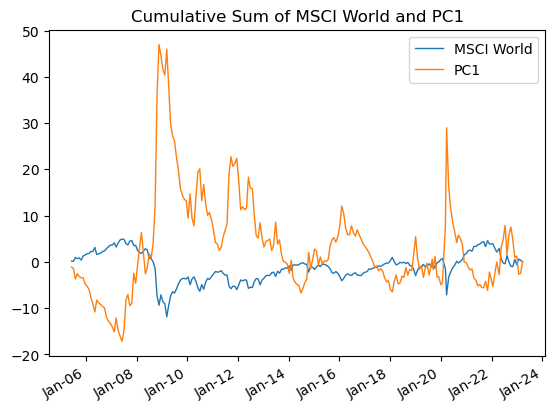

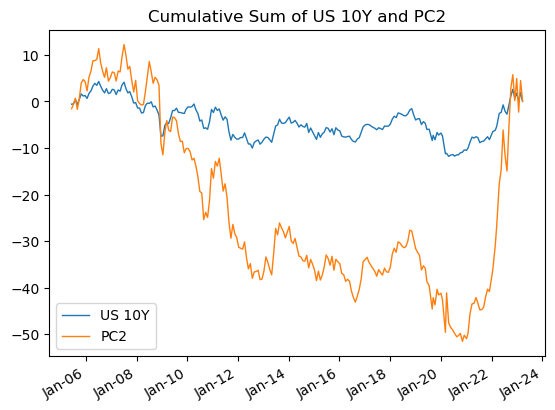

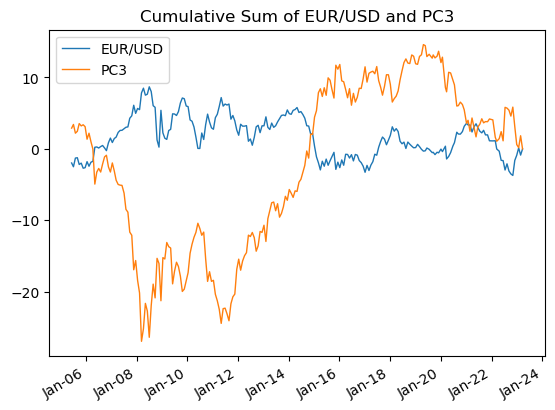

In [20]:
# Loop through the first three principal components
for pc in ['PC1', 'PC2', 'PC3']:
    best_factor = best_factors_df.at['Best Factor', pc]

    # Prepare data for plotting
    plot_data = pd.DataFrame()
    plot_data[best_factor] = data_pca_normalised[best_factor].cumsum()
    plot_data[pc] = scores_df[pc].cumsum()

    # Use the custom function for plotting
    fig, ax = plot_timeseries_one_axis(plot_data);
    ax.set_title(f"Cumulative Sum of {best_factor} and {pc}")
    ax.legend()
    plt.show()

# 3. Study of the Traditional Assets

In [21]:
# Read Data

change_freq = '4w'
data_trad = pd.read_csv(filepath_or_buffer='_'.join(['Traditional Assets_Multi-asset PCA', 'CHANGES=' + change_freq]) + '.csv',
                      index_col=0, header=0,
                      parse_dates=True).astype(np.float64)

n_assets_trad = data_trad.shape[1]

In [22]:
data_trad

US Govt. Bonds  European Govt. Bonds  US IG Corp. Bonds  \
2005-06-10        0.010386              0.017674           0.013421   
2005-07-06        0.001192             -0.004078           0.002829   
2005-08-03       -0.008140             -0.005336          -0.004783   
2005-08-31        0.016193              0.015940           0.016234   
2005-09-27       -0.011720              0.000517          -0.014359   
...                    ...                   ...                ...   
2022-11-30        0.026953              0.022098           0.047535   
2022-12-28       -0.006943             -0.045961          -0.006454   
2023-01-25        0.028097              0.030792           0.041032   
2023-02-22       -0.025541             -0.026568          -0.031878   
2023-03-22        0.029796              0.014531           0.023493   

            European IG Corp. Bonds  US High Yield  European High Yield  \
2005-06-10                 0.019308       0.029171             0.029893   
2005-07-06                -0.002100       0.009255             0.009683   
2005-08-03                -0.005385       0.015161             0.014480   
2005-08-31                 0.016116       0.003449             0.007675   
2005-09-27                -0.000039      -0.009020             0.001002   
...                             ...            ...                  ...   
2022-11-30                 0.025662       0.021258             0.032360   
2022-12-28                -0.019763      -0.006197            -0.008446   
2023-01-25                 0.027126       0.035909             0.029603   
2023-02-22                -0.012932      -0.019851             0.002439   
2023-03-22                -0.000127       0.005266            -0.009522   

            MSCI World   S&P 500  Crude Oil  Industrial Metals  \
2005-06-10    0.014866  0.024410   0.028562           0.012891   
2005-07-06    0.003253 -0.001373   0.112833          -0.011761   
2005-08-03    0.047262  0.042098  -0.020653           0.067694   
2005-08-31   -0.006708 -0.018139   0.105520           0.000730   
2005-09-27    0.011620 -0.002921  -0.064567           0.019788   
...                ...       ...        ...                ...   
2022-11-30    0.086199  0.083794  -0.098184           0.092527   
2022-12-28   -0.054265 -0.074297  -0.023005           0.026770   
2023-01-25    0.068924  0.060770   0.013441           0.066096   
2023-02-22   -0.008393 -0.004677  -0.081716          -0.072963   
2023-03-22   -0.014729 -0.011974  -0.045359          -0.064751   

            Precious Metals  
2005-06-10         0.005019  
2005-07-06        -0.022402  
2005-08-03         0.033755  
2005-08-31        -0.027033  
2005-09-27         0.063330  
...                     ...  
2022-11-30         0.066374  
2022-12-28         0.045765  
2023-01-25         0.052185  
2023-02-22        -0.070958  
2023-03-22         0.053697  

[232 rows x 11 columns]

In [23]:
# Normalise the data to have zero mean and standard deviation 1; show the normalised data

data_trad_normalised = (data_trad - data_trad.mean()) / data_trad.std()
data_trad_normalised

US Govt. Bonds  European Govt. Bonds  US IG Corp. Bonds  \
2005-06-10        0.637123              1.088591           0.489450   
2005-07-06       -0.067827             -0.391676          -0.009991   
2005-08-03       -0.783406             -0.477266          -0.368965   
2005-08-31        1.082408              0.970536           0.622093   
2005-09-27       -1.057891             -0.078988          -0.820468   
...                    ...                   ...                ...   
2022-11-30        1.907484              1.389646           2.098054   
2022-12-28       -0.691614             -3.241830          -0.447752   
2023-01-25        1.995159              1.981227           1.791424   
2023-02-22       -2.117699             -1.922162          -1.646589   
2023-03-22        2.125446              0.874675           0.964376   

            European IG Corp. Bonds  US High Yield  European High Yield  \
2005-06-10                 1.186558       0.785765             0.764510   
2005-07-06                -0.261775       0.146020             0.152702   
2005-08-03                -0.483981       0.335740             0.297913   
2005-08-31                 0.970584      -0.040484             0.091916   
2005-09-27                -0.122343      -0.441008            -0.110103   
...                             ...            ...                  ...   
2022-11-30                 1.616380       0.531607             0.839217   
2022-12-28                -1.456655      -0.350336            -0.396110   
2023-01-25                 1.715428       1.002223             0.755746   
2023-02-22                -0.994542      -0.788922            -0.066579   
2023-03-22                -0.128285       0.017894            -0.428692   

            MSCI World   S&P 500  Crude Oil  Industrial Metals  \
2005-06-10    0.183719  0.345216   0.322210           0.165716   
2005-07-06   -0.037128 -0.159374   1.077765          -0.203723   
2005-08-03    0.799827  0.691387  -0.119036           0.987022   
2005-08-31   -0.226582 -0.487514   1.012196          -0.016538   
2005-09-27    0.121989 -0.189670  -0.512761           0.269072   
...                ...       ...        ...                ...   
2022-11-30    1.540318  1.507397  -0.814159           1.359171   
2022-12-28   -1.131010 -1.586561  -0.140126           0.373712   
2023-01-25    1.211784  1.056797   0.186639           0.963064   
2023-02-22   -0.258620 -0.224048  -0.666516          -1.120919   
2023-03-22   -0.379119 -0.366858  -0.340540          -0.997850   

            Precious Metals  
2005-06-10         0.007486  
2005-07-06        -0.485432  
2005-08-03         0.524058  
2005-08-31        -0.568689  
2005-09-27         1.055710  
...                     ...  
2022-11-30         1.110415  
2022-12-28         0.739942  
2023-01-25         0.855358  
2023-02-22        -1.358291  
2023-03-22         0.882534  

[232 rows x 11 columns]

In [24]:
pca_trad = pca.PCA(data=data_trad_normalised.values, standardize=True, normalize=False)
loadings_trad = pca_trad.loadings
scores_trad = pca_trad.scores
explained_variance_trad = pca_trad.eigenvals
explained_variance_ratio_trad = explained_variance_trad / explained_variance_trad.sum() * 100
cumulative_explained_variance_ratio_trad = np.cumsum(explained_variance_ratio_trad)

In [25]:
loadings_trad_df = pd.DataFrame(
    index=data_trad_normalised.columns,
    columns=[''.join(['PC', str(j + 1)]) for j in range(n_assets_trad)],
    data=loadings_trad)

scores_trad_df = pd.DataFrame(
    index=data_trad_normalised.index,
    columns=[''.join(['PC', str(i + 1)]) for i in range(n_assets_trad)],
    data=scores_trad)

In [26]:
var_explained_trad_df = pd.DataFrame(
    {
        "Dim": [x for x in range(1, len(explained_variance_trad) + 1)],
        "% var. explained": explained_variance_ratio_trad,
        "% cum. var. explained": cumulative_explained_variance_ratio_trad
    }
).set_index('Dim')
var_explained_trad_df

% var. explained  % cum. var. explained
Dim                                         
1           46.628907              46.628907
2           22.968751              69.597658
3           10.418276              80.015934
4            6.599419              86.615353
5            4.322212              90.937565
6            3.884804              94.822369
7            3.014014              97.836383
8            1.055166              98.891549
9            0.646350              99.537898
10           0.346765              99.884663
11           0.115337             100.000000

In [27]:
# Compute the correlation of each asset with PC1 and PC2
correlation_trad_pc1 = data_trad_normalised.corrwith(scores_trad_df['PC1'])
correlation_trad_pc2 = data_trad_normalised.corrwith(scores_trad_df['PC2'])

# Create a DataFrame to display the correlations
correlation_trad_df = pd.DataFrame({
    'PC1': correlation_trad_pc1,
    'PC2': correlation_trad_pc2
}, index=data_trad_normalised.columns)

correlation_trad_df.style.format(formatter='{:+.2f}').map(func=lambda x: 'color:red' if x < 0. else 'color:blue')

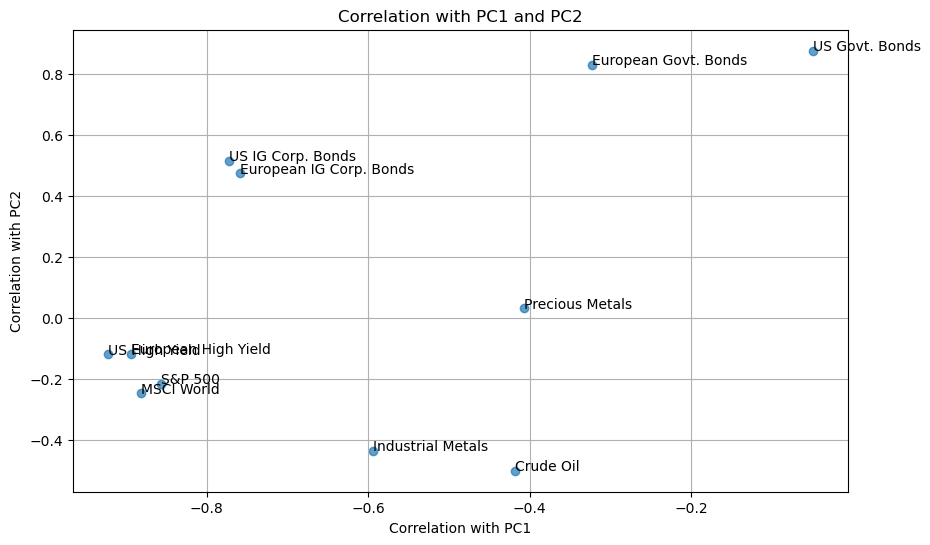

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(correlation_trad_df['PC1'], correlation_trad_df['PC2'], alpha=0.7)

# Ajouter les noms des points
for i in correlation_trad_df.index:
    plt.text(correlation_trad_df.loc[i, 'PC1'], correlation_trad_df.loc[i, 'PC2'], i)

# Ajouter des titres et des étiquettes
plt.title("Correlation with PC1 and PC2")
plt.xlabel("Correlation with PC1")
plt.ylabel("Correlation with PC2")
plt.grid(True)
plt.show()

# 4. Systematic Strategies

In [29]:
# Read Data

change_freq = '4w'
data_syst = pd.read_csv(filepath_or_buffer='_'.join(['Systematic Strategies_Multi-asset PCA', 'CHANGES=' + change_freq]) + '.csv',
                      index_col=0, header=0,
                      parse_dates=True).astype(np.float64)

n_assets_syst = data_syst.shape[1]

In [30]:
data_syst

Global Quality Income vs. Index  Global Equity Machine Learning  \
2005-06-10                         0.051755                             NaN   
2005-07-06                         0.013968                             NaN   
2005-08-03                        -0.045271                             NaN   
2005-08-31                         0.008821                             NaN   
2005-09-27                         0.028851                             NaN   
...                                     ...                             ...   
2022-11-30                        -0.047987                       -0.013439   
2022-12-28                         0.017136                        0.003181   
2023-01-25                        -0.050958                       -0.003026   
2023-02-22                         0.020082                        0.021498   
2023-03-22                        -0.011847                        0.006434   

            European Value vs. Index  Commodity Congestion  Multi-asset Trend  \
2005-06-10                  0.014358              0.024636           0.026185   
2005-07-06                  0.008676              0.003710           0.011092   
2005-08-03                  0.010801              0.000871          -0.003290   
2005-08-31                  0.007892              0.002410           0.020470   
2005-09-27                 -0.004355              0.002619           0.012372   
...                              ...                   ...                ...   
2022-11-30                  0.011862              0.018969          -0.038204   
2022-12-28                  0.011447              0.006698           0.002398   
2023-01-25                  0.033966              0.005789          -0.030022   
2023-02-22                  0.011651              0.019872           0.000874   
2023-03-22                 -0.025383             -0.003288          -0.039426   

            Repo Carry  Long Rates Vol.  Tail Hedge -SDV  Tail Hedge - SCV  \
2005-06-10         NaN              NaN          -0.3152               NaN   
2005-07-06         NaN              NaN          -0.9980               NaN   
2005-08-03         NaN              NaN           0.0469               NaN   
2005-08-31         NaN              NaN          -0.3767               NaN   
2005-09-27         NaN              NaN          -0.5122               NaN   
...                ...              ...              ...               ...   
2022-11-30    0.008922        -0.000696           1.6405          0.011194   
2022-12-28   -0.004487         0.016413          -4.3861         -0.015289   
2023-01-25    0.012565        -0.028874          -0.7273          0.016171   
2023-02-22   -0.002980         0.022189          -0.4369         -0.004838   
2023-03-22   -0.004457        -0.004162           0.6684          0.000329   

            Tail Hedge - Dynamic Put Ratio  Put Spread  \
2005-06-10                             NaN   -0.005487   
2005-07-06                             NaN   -0.000930   
2005-08-03                             NaN   -0.006943   
2005-08-31                             NaN    0.002420   
2005-09-27                             NaN   -0.000688   
...                                    ...         ...   
2022-11-30                       -0.002338   -0.024075   
2022-12-28                        0.005956    0.022461   
2023-01-25                        0.004102   -0.023007   
2023-02-22                        0.000700    0.001410   
2023-03-22                       -0.000871    0.002799   

            Intraday Trend Following  Strong vs. Weak Balance Sheets  \
2005-06-10                       NaN                             NaN   
2005-07-06                       NaN                             NaN   
2005-08-03                       NaN                             NaN   
2005-08-31                       NaN                             NaN   
2005-09-27                       NaN                             NaN   
...                     

Some columns contain missing values. Let's check the proportion of missing values in each column :

In [31]:
# Null values in dataset

null = data_syst.isnull().sum().sort_values(ascending=False)
percent_missing = (data_syst.isnull().sum() / data_syst.shape[0] * 100).sort_values(ascending=False)

missing_data = pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])
missing_data = missing_data.rename(columns= { "index": " column name"})

missing_data.sort_values(by ='Total missing', ascending = False)

Total missing  Percent missing
Tail Hedge - SCV                           147        63.362069
Long Rates Vol.                             96        41.379310
Repo Carry                                  86        37.068966
Intraday Trend Following                    35        15.086207
Short Weekly Tail Puts                      35        15.086207
Strong vs. Weak Balance Sheets              34        14.655172
Global Equity Machine Learning               9         3.879310
Tail Hedge - Dynamic Put Ratio               9         3.879310
Global Quality Income vs. Index              0         0.000000
European Value vs. Index                     0         0.000000
Commodity Congestion                         0         0.000000
Multi-asset Trend                            0         0.000000
Tail Hedge -SDV                              0         0.000000
Put Spread                                   0         0.000000
FX Carry                                     0         0.000000
FX Value                                     0         0.000000

**Many columns have too many missing values, so we can't fill in the missing data with sample means, medians or other rudimentary interpolations that will overwhelm out the signal of the data with noise. More, if those columns are removed, there's a risk of losing too much information. So, we will use probabilistic PCA which compute factors where some of the data are missing.**

In [32]:
# Create Probabilistic PCA (PPCA) object
ppca = PPCA();

# Number of pricipal components
n_pc = 2

# Fit the PPCA model with principal components
ppca.fit(data=data_syst.values, d=n_pc, verbose=True)

# Obtain the principal components
component_mat = ppca.transform();

1.0
0.618056581124523
0.7651531498414534
1.203135286667274
1.5499705981710017
0.0011188891781173105
0.11319725368736777
0.11430824999600864
0.09157494114566223
0.06650094553793218
0.04553397088846789
0.0299551539201115
0.019142279607631596
0.011960724188112226
0.007333540911333869
0.004417712017541375
0.0026123623359801673
0.001511662109635159
0.0008506278803277478
0.0004601301419767667
0.0002339788684333488
0.00010635904289635345
3.693741717225585e-05


In [33]:
variance_explained = ppca.var_exp
components = ppca.data
model_params = ppca.C

In [34]:
scores_syst_df = pd.DataFrame(
    index=data_syst.index,
    columns=[''.join(['PC', str(i + 1)]) for i in range(n_pc)],
    data=component_mat)

scores_syst_df

PC1       PC2
2005-06-10  0.885649 -1.143361
2005-07-06  0.315976  0.200394
2005-08-03 -1.175328 -0.318439
2005-08-31  0.413589  0.317967
2005-09-27  0.105919  0.312218
...              ...       ...
2022-11-30 -0.331789 -2.103379
2022-12-28  0.693087  2.270580
2023-01-25 -2.094762 -2.071988
2023-02-22  0.031799  0.316783
2023-03-22  0.501183  0.946036

[232 rows x 2 columns]

In [35]:
# Compute the correlation of each asset with PC1 and PC2
correlation_syst_pc1 = data_syst.corrwith(scores_syst_df['PC1'])
correlation_syst_pc2 = data_syst.corrwith(scores_syst_df['PC2'])

# Create a DataFrame to display the correlations
correlation_syst_df = pd.DataFrame({
    'PC1': correlation_syst_pc1,
    'PC2': correlation_syst_pc2
}, index=data_syst.columns)

correlation_syst_df.style.format(formatter='{:+.2f}').map(func=lambda x: 'color:red' if x < 0. else 'color:blue')

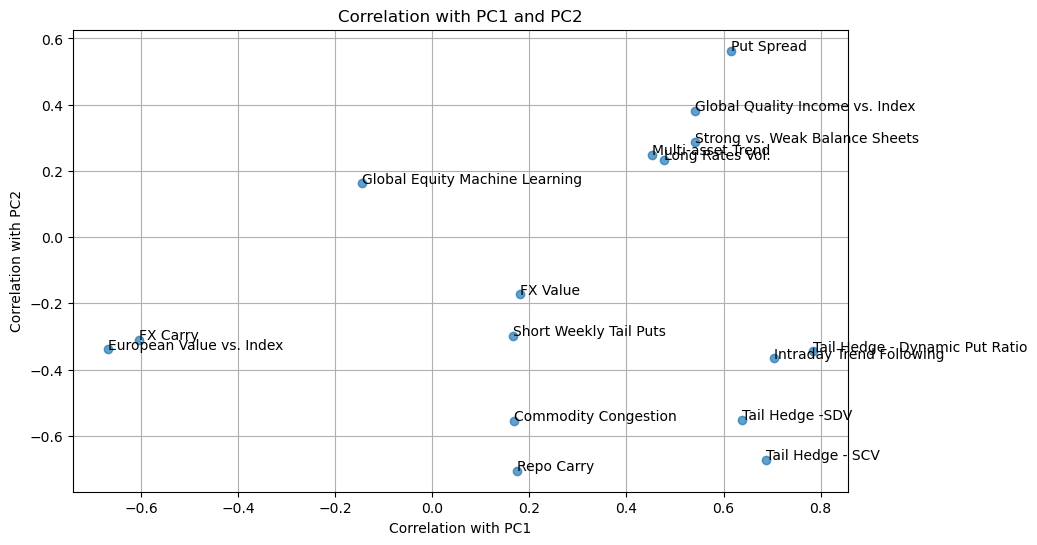

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(correlation_syst_df['PC1'], correlation_syst_df['PC2'], alpha=0.7)

# Ajouter les noms des points
for i in correlation_syst_df.index:
    plt.text(correlation_syst_df.loc[i, 'PC1'], correlation_syst_df.loc[i, 'PC2'], i)

# Ajouter des titres et des étiquettes
plt.title("Correlation with PC1 and PC2")
plt.xlabel("Correlation with PC1")
plt.ylabel("Correlation with PC2")
plt.grid(True)
plt.show()

# 5. Portfolio Optimization

    Data

In [37]:
equity_data = pd.read_csv('equity_factor_performance_data.csv',
                            index_col=0, header=0,
                            parse_dates=True).astype(np.float64)

In [38]:
equity_data

Growth     Low Risk     Low Size      Momentum        Value  \
2018-09-03  3147.275589  2521.365122  4447.639970   7230.019236  5367.396587   
2018-09-04  3147.869877  2517.854224  4423.624532   7240.434396  5339.050310   
2018-09-05  3123.127074  2512.737537  4432.075319   7221.320382  5358.611721   
2018-09-06  3106.574794  2518.676856  4399.732989   7182.130965  5311.798170   
2018-09-07  3101.329324  2510.221028  4376.879336   7139.770025  5291.714564   
...                 ...          ...          ...           ...          ...   
2023-08-28  4722.945678  4272.219410  5360.124710  11363.308993  7459.215794   
2023-08-29  4806.024404  4309.305708  5436.687835  11535.042889  7543.478208   
2023-08-30  4841.395229  4326.786715  5465.827827  11598.645379  7544.416986   
2023-08-31  4852.078911  4308.159090  5473.408710  11640.134272  7521.389497   
2023-09-01  4884.347114  4317.863443  5501.348987  11709.032625  7570.535386   

            Quality Income  
2018-09-03     2746.458678  
2018-09-04     2744.511885  
2018-09-05     2765.911701  
2018-09-06     2752.442728  
2018-09-07     2749.406337  
...                    ...  
2023-08-28     4465.448906  
2023-08-29     4482.673495  
2023-08-30     4483.233991  
2023-08-31     4450.985502  
2023-09-01     4448.521921  

[1305 rows x 6 columns]

Next, we find the simple daily returns for each of the 12 assets using the `pct_change()` method, since our data object is a `pandas` DataFrame. We use simple returns since they have the property of being asset-additive, which is necessary since we need to compute portfolios returns:

In [39]:
# Compute daily simple returns
daily_returns = (
  equity_data.pct_change()
            .dropna(
              # Drop the first row since we have NaN's
              # The first date 2018-09-03 does not have a value since it is our cut-off date
              axis = 0,
              how = 'any',
              inplace = False
              )
)
# Examine the last 5 rows
daily_returns.tail(n = 5)

Growth  Low Risk  Low Size  Momentum     Value  Quality Income
2023-08-28  0.005015  0.006035  0.005886  0.006481  0.007407        0.003419
2023-08-29  0.017590  0.008681  0.014284  0.015113  0.011296        0.003857
2023-08-30  0.007360  0.004057  0.005360  0.005514  0.000124        0.000125
2023-08-31  0.002207 -0.004305  0.001387  0.003577 -0.003052       -0.007193
2023-09-01  0.006650  0.002253  0.005105  0.005919  0.006534       -0.000553

The simple daily returns may be visualized using line charts, density plots, and histograms, which are covered in my other post on visualizing asset data. Even though the visualizations in that post use the ggplot2 package in R, the plotnine package, or any other Python graphics librarires, can be employed to produce them in Python. For now, let us annualize the daily returns over the 5-year period from 2018-09-03 to 2023-09-01. We assume the number of trading days in a year is computed as follows:

$$365.25 \quad \text{(days on average per year)} \cdot \frac{5}{7} \quad \text{(proportion work days per week)} - 6 \quad \text{(weekday holidays)} - 3 \cdot \frac{5}{7} \quad \text{(fixed date holidays)} = 252.75 \approx 253$$

In [40]:
daily_returns.mean() * 253

Growth            0.117797
Low Risk          0.122932
Low Size          0.084286
Momentum          0.118064
Value             0.103472
Quality Income    0.111360
dtype: float64

The annualized variance-covariance matrix of the returns can be computed using built-in `pandas` method `cov()`:

In [41]:
daily_returns.cov() * 253

Growth  Low Risk  Low Size  Momentum     Value  \
Growth          0.064674  0.044142  0.062492  0.050407  0.056067   
Low Risk        0.044142  0.036917  0.042614  0.039387  0.040846   
Low Size        0.062492  0.042614  0.085696  0.053194  0.077119   
Momentum        0.050407  0.039387  0.053194  0.048724  0.051333   
Value           0.056067  0.040846  0.077119  0.051333  0.073120   
Quality Income  0.034156  0.029625  0.043524  0.034334  0.043255   

                Quality Income  
Growth                0.034156  
Low Risk              0.029625  
Low Size              0.043524  
Momentum              0.034334  
Value                 0.043255  
Quality Income        0.035410

**Minimize Risk given Levels of Return**

$$\min _{\vec{w}} \sqrt{\vec{w}^T \hat{\Sigma} \vec{w}}$$

subject to
$$
\begin{aligned}
& \vec{w}^T \hat{\mu}=\overline{r}_P \\
& \vec{w}^T \vec{1}=1 \quad \text { (Full investment) } \\
& \overrightarrow{0} \leq \vec{w} \leq \vec{1} \quad \text { (Long only) }
\end{aligned}
$$

**Maximize Return given Levels of Risk**

$$\max _{\vec{w}} \vec{w}^T \hat{\mu}$$

subject to

$$\begin{aligned} & \vec{w}^T \hat{\Sigma} \vec{w}=\overline{\sigma}_P \\ & \vec{w}^T \overrightarrow{1}=1 \quad \text { (Full investment) } \\ & \overrightarrow{0} \leq \vec{w} \leq \overrightarrow{1} \quad \text { (Long only) }\end{aligned}$$

In absence of other constraints, the above model is loosely referred to as the
*"unconstrained"* portfolio optimization model. Solving the mathematical model yields a set of optimal weights representing a set of optimal portfolios.

## 5.1 Monte Carlo Simulation

The first task is to simulate a random set of portfolios to visualize the risk-return profiles of our given set of assets. We use a for loop to simulate random vectors of asset weights, computing the expected portfolio return and standard deviation for each permutation of random weights. Again, we ensure that each random weight vector is subject to the long-positions-only and full-investment constraints.

    Monte Carlo Simulation

The empty containers we instantiate are lists; they are mutable and so growing them will not be memory inefficient.

In [42]:
# instantiate empty list containers for returns and sd
list_portfolio_returns = []
list_portfolio_sd = []
# For loop to simulate 5000 random weight vectors (numpy array objects)
for p in range(5000):
  # Return random floats in the half-open interval [0.0, 1.0)
  weights = np.random.random(size = equity_data.shape[1])
  # Normalize to unity
  # The /= operator divides the array by the sum of the array and rebinds "weights" to the new object
  weights /= np.sum(weights)
  # Lists are mutable so growing will not be memory inefficient
  list_portfolio_returns.append(portfolio_returns(daily_returns, weights))
  list_portfolio_sd.append(portfolio_sd(daily_returns, weights))
  # Convert list to numpy arrays
  port_returns = np.array(object = list_portfolio_returns)
  port_sd = np.array(object = list_portfolio_sd)

Let us examine the simulation results. In particular, the highest and the lowest expected portfolio returns are as follows:

In [43]:
# Max expected return
max_expected_return = round(max(port_returns), 4)

# Min expected return
min_expected_return = round(min(port_returns), 4)

print(f'Highest expected portfolio returns : {max_expected_return}\nLowest expected portfolio returns : {min_expected_return}')

Highest expected portfolio returns : 0.119
Lowest expected portfolio returns : 0.0922


On the other hand, the highest and lowest volatility measures are recorded as:

In [44]:
# Max sd
max_vol = round(max(port_sd), 4)

# Min sd
min_vol = round(min(port_sd), 4)

print(f'Highest volatility measure : {max_vol}\nLowest volatility measure : {min_vol}')

Highest volatility measure : 0.2694
Lowest volatility measure : 0.1863


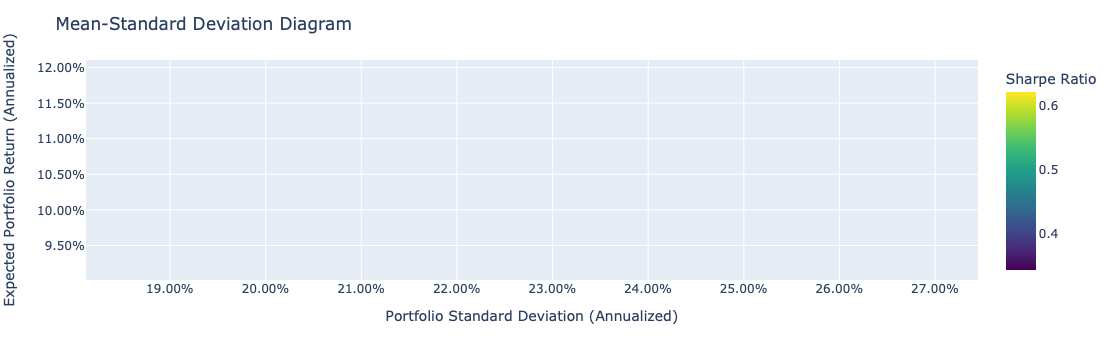

In [45]:
sharpe_ratio = [r / sd for r, sd in zip(port_returns, port_sd)]  # Sharpe Ratio calculation

# Create a scatter plot
fig = px.scatter(
    x=port_sd, y=port_returns, color=sharpe_ratio,
    labels={'x': 'Portfolio Standard Deviation (Annualized)', 'y': 'Expected Portfolio Return (Annualized)'},
    color_continuous_scale='Viridis',  # You can choose any color scale
)

# Update layout
fig.update_layout(
    title='Mean-Standard Deviation Diagram',
    xaxis_tickformat='.2%',
    yaxis_tickformat='.2%',
)

# Add colorbar title
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

# Show the plot
fig.show()

Each point in the diagram above represents a permutation of expected-return-standard-deviation value pair. The points are color coded such that the magnitudes of the Sharpe ratios, defined as $SR = \frac{\mu_P - r_f}{\sigma_P}$, can be readily observed for each expected-return-standard-deviation pairing. For simplicity, we assume that $r_f \equiv 0$.

## 5.2 Optimal Portfolio

We will use dictionaries inside of a tuple to represent the constraints:

In [46]:
#We use an anonymous lambda function
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

Next, the bound values for the weights:

In [47]:
# This creates 12 tuples of (0, 1), all of which exist within a container tuple
# We essentially create a sequence of (min, max) pairs
bounds = tuple(
  (0, 1) for w in weights
)

We also need to supply a starting list of weights, which essentially functions as an initial guess. For our purposes, this will be an equal weight array:

In [48]:
# Repeat the list with the value (1 / 12) 12 times, and convert list to array
equal_weights = np.array(
  [1 / equity_data.shape[1]] * equity_data.shape[1]
)

    Minimum Variance Portfolio

In [49]:
# Minimize sd
min_sd_results = minimize(
  # Objective function
  fun = lambda weights: portfolio_sd(daily_returns, weights),
  # Initial guess, which is the equal weight array
  x0 = equal_weights,
  method = 'SLSQP',
  bounds = bounds,
  constraints = constraints
)

    Minimum Variance Weights

In [50]:
optimal_weights_df = pd.DataFrame(
    min_sd_results.x.reshape(1, -1),
    columns=equity_data.columns,
    index=['Weights']
)
optimal_weights_df

Growth  Low Risk  Low Size      Momentum  Value  Quality Income
Weights  2.832792e-17  0.434213       0.0  3.469447e-17    0.0        0.565787

    Expected return (Minimum variance portfolio)

In [51]:
# Expected return
min_sd_port_return = portfolio_returns(daily_returns, min_sd_results["x"])
print(f'Expected return (Minimum variance portfolio) : {round(min_sd_port_return, 4)}')

Expected return (Minimum variance portfolio) : 0.1164


    Standard deviation (Minimum variance portfolio)

In [52]:
# Standard deviation
min_sd_port_sd = portfolio_sd(daily_returns, min_sd_results["x"])
print(f'Standard deviation (Minimum variance portfolio) : {round(min_sd_port_sd, 4)}')

Standard deviation (Minimum variance portfolio) : 0.1813


    Sharpe ratio (Minimum variance portfolio)

In [53]:
# Sharpe ratio
min_sd_port_sharpe = min_sd_port_return / min_sd_port_sd
print(f'Sharpe ratio (Minimum variance portfolio) : {round(min_sd_port_sharpe, 4)}')

Sharpe ratio (Minimum variance portfolio) : 0.6421


    Portfolio returns (Minimum variance portfolio)

In [54]:
# Calculate the portfolio returns
min_var_returns = daily_returns.dot(min_sd_results.x)

# Calculate the cumulative sum of the portfolio returns
cumulative_portfolio_returns = min_var_returns.cumsum()

print(f'Portfolio returns :\n{min_var_returns}')

Portfolio returns :
2018-09-04   -0.001006
2018-09-05    0.003529
2018-09-06   -0.001729
2018-09-07   -0.002082
2018-09-10    0.003524
                ...   
2023-08-28    0.004555
2023-08-29    0.005952
2023-08-30    0.001832
2023-08-31   -0.005939
2023-09-01    0.000665
Length: 1304, dtype: float64


In [55]:
print(f'Cumulative sum of the portfolio returns :\n{cumulative_portfolio_returns}')

Cumulative sum of the portfolio returns :
2018-09-04   -0.001006
2018-09-05    0.002524
2018-09-06    0.000795
2018-09-07   -0.001287
2018-09-10    0.002237
                ...   
2023-08-28    0.597355
2023-08-29    0.603306
2023-08-30    0.605138
2023-08-31    0.599199
2023-09-01    0.599864
Length: 1304, dtype: float64


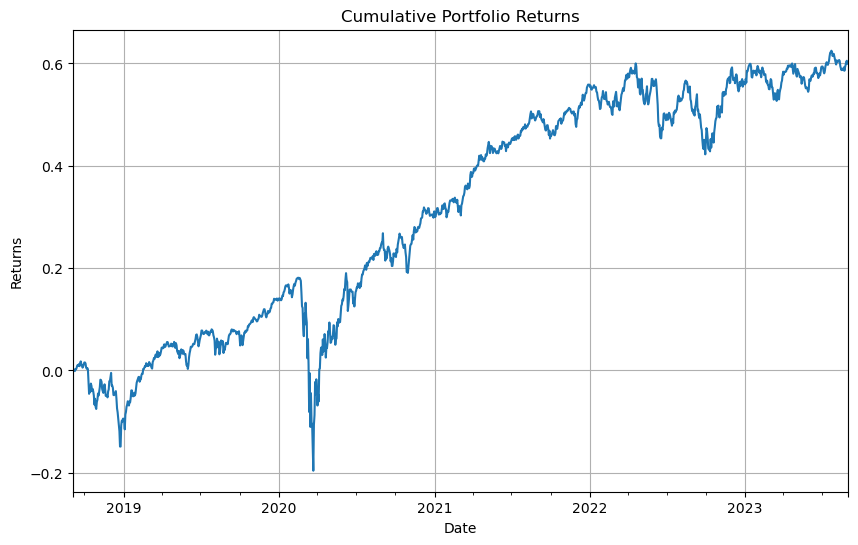

In [56]:
cumulative_portfolio_returns.plot(figsize=(10, 6), title='Cumulative Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

## 5.3 Montly returns

In [57]:
monthly_returns = daily_returns.resample('M').mean()
monthly_returns

Growth  Low Risk  Low Size  Momentum     Value  Quality Income
2018-09-30 -0.000167  0.000365 -0.000378 -0.000243 -0.000501        0.000807
2018-10-31 -0.003609 -0.003088 -0.003346 -0.003682 -0.003459       -0.002948
2018-11-30  0.001195  0.001793  0.001014  0.000604  0.000948        0.002154
2018-12-31 -0.003959 -0.003589 -0.006433 -0.004351 -0.006041       -0.004041
2019-01-31  0.004349  0.003074  0.005121  0.003790  0.005254        0.003030
...              ...       ...       ...       ...       ...             ...
2023-05-31  0.002010 -0.001470 -0.001162 -0.000650 -0.001563       -0.002844
2023-06-30  0.002927  0.002691  0.003978  0.003729  0.004115        0.001798
2023-07-31  0.002206  0.000128  0.002703  0.001105  0.002793        0.002094
2023-08-31 -0.001349 -0.000435 -0.001557 -0.000717 -0.001546       -0.001160
2023-09-30  0.006650  0.002253  0.005105  0.005919  0.006534       -0.000553

[61 rows x 6 columns]

In [58]:
expected_returns = monthly_returns.shift()
expected_returns

Growth  Low Risk  Low Size  Momentum     Value  Quality Income
2018-09-30       NaN       NaN       NaN       NaN       NaN             NaN
2018-10-31 -0.000167  0.000365 -0.000378 -0.000243 -0.000501        0.000807
2018-11-30 -0.003609 -0.003088 -0.003346 -0.003682 -0.003459       -0.002948
2018-12-31  0.001195  0.001793  0.001014  0.000604  0.000948        0.002154
2019-01-31 -0.003959 -0.003589 -0.006433 -0.004351 -0.006041       -0.004041
...              ...       ...       ...       ...       ...             ...
2023-05-31 -0.001177  0.001036 -0.000830 -0.000117 -0.000531        0.000869
2023-06-30  0.002010 -0.001470 -0.001162 -0.000650 -0.001563       -0.002844
2023-07-31  0.002927  0.002691  0.003978  0.003729  0.004115        0.001798
2023-08-31  0.002206  0.000128  0.002703  0.001105  0.002793        0.002094
2023-09-30 -0.001349 -0.000435 -0.001557 -0.000717 -0.001546       -0.001160

[61 rows x 6 columns]

### 5.3 Long-Only

At the begining of each month, we construct a portfolio using the following constraints :

    - expected return : past month performance – long only
    - total allocation 1
    - cannot trade more than 0.05 per factor
    - each factor cannot be allocated more than 0.25
    - total trading cannot be more than 0.15

In [59]:
def optimize_portfolio_long_only(returns, previous_position,
                                 trade_limit_per_factor=0.05, 
                                 max_factor_allocation=0.25, 
                                 total_trade_limit=0.15):
    """
    Calculate new portfolio positions with long-only constraint, based on previous positions and returns,
    incorporating trading limits and factor allocation constraints.

    Parameters
    ----------
    previous_position : pd.Series
        The portfolio's previous positions, indexed by factors.
    returns : pd.DataFrame
        Asset returns, with rows as timestamps and columns as factors.
    trade_limit_per_factor : float, optional
        The maximum change (increase or decrease) allowed per factor, default is 0.05.
    max_factor_allocation : float, optional
        The maximum allocation allowed for any single factor, default is 0.25.
    total_trade_limit : float, optional
        The total allowed change in the portfolio, measured as the 1-norm difference between
        the new and previous positions, default is 0.15.

    Returns
    -------
    new_positions : pd.Series
                    A series of the new positions for each factor, maintaining the index of previous_position.
    
    Notes
    -----
    This function uses convex optimization (cvxpy) to find the new positions that minimize the negative
    of the portfolio's returns under the given constraints. It's assumed that all positions are long-only.
    """
    # Number of factors
    nb_factor = returns.shape[0]
    
    # Identity matrices for constraints
    id_matrix = np.identity(nb_factor)
    id_neg_matrix = -np.identity(nb_factor)
    
    # Stack identity matrices for constraints
    stacked_id = np.vstack([id_matrix, id_neg_matrix])
    
    # Constraints for trading limits and allocations
    constraint1 = (
        previous_position + trade_limit_per_factor
    ).apply(lambda weight: min(weight, max_factor_allocation)).values.reshape((nb_factor, 1))
    
    constraint2 = -(
        previous_position - trade_limit_per_factor
    ).apply(lambda weight: max(weight, 0)).values.reshape((nb_factor, 1)) # Bounds 0 because long only
    
    # Combine constraints
    constraints = np.vstack([constraint1, constraint2]).flatten()
    
    # Total allocation constraint
    A = np.ones((1, nb_factor))
    total_allocation = 1
    
    # Optimization variable
    weights = cp.Variable(nb_factor)
    
    # Define the optimization problem
    max_returns_weights = cp.Problem(
        cp.Minimize(-returns.values.T @ weights),
        [
            stacked_id @ weights <= constraints,
            A @ weights == total_allocation,
            cp.norm1(weights - previous_position.values) <= total_trade_limit
        ]
    )
    
    # Solve the optimization problem
    max_returns_weights.solve()
    
    # Return new positions as a Pandas Series
    return pd.Series(weights.value, index=previous_position.index)

In [60]:
optimized_weights_long_only = [pd.Series(1 / monthly_returns.shape[1], monthly_returns.columns)]

for date in monthly_returns.index[1:]:
  optimized_weights_long_only.append(optimize_portfolio_long_only(expected_returns.xs(date), optimized_weights_long_only[-1]))
    
optimized_weights_long_only = pd.DataFrame(optimized_weights_long_only, index=monthly_returns.index)

In [61]:
# Calculate and display the PnL
# Shift the weights, as returns are realized in the next month
long_only_portfolio_returns = (optimized_weights_long_only.shift() * monthly_returns).sum(axis=1)
monthly_pnl_long_only = long_only_portfolio_returns.cumsum()
monthly_pnl_long_only

2018-09-30    0.000000
2018-10-31   -0.003355
2018-11-30   -0.001991
2018-12-31   -0.006523
2019-01-31   -0.002661
                ...   
2023-05-31    0.021257
2023-06-30    0.024310
2023-07-31    0.025829
2023-08-31    0.024812
2023-09-30    0.029264
Freq: M, Length: 61, dtype: float64

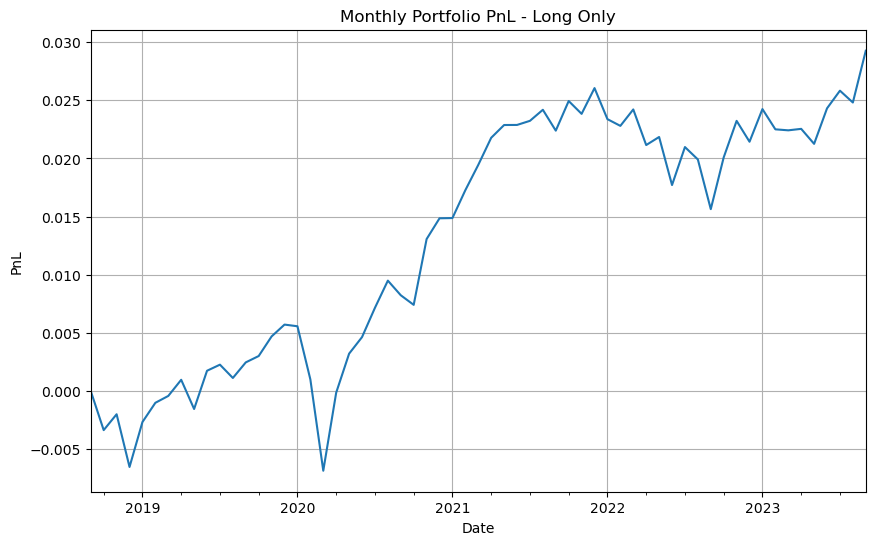

In [62]:
# Plot the PnL
monthly_pnl_long_only.plot(figsize=(10, 6), title='Monthly Portfolio PnL - Long Only')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

### 5.3 Long-Short

We will perform the same monthly portfolio optimization, but this time we are permitted to take short positions and must ensure that the Gross Market Value (GMV) of the portfolio is precisely 1.

In [63]:
def optimize_portfolio_long_short(returns, previous_position,
                                  trade_limit_per_factor=0.05, 
                                  max_factor_allocation=0.25, 
                                  total_trade_limit=0.15,
                                  gmv=1):
    """
    Calculate new portfolio positions, allowing for both long and short positions, 
    based on previous positions and expected returns. This function incorporates 
    trading limits and factor allocation constraints to determine the optimal 
    allocation that maximizes returns under the specified constraints.

    Parameters
    ----------
    returns : pd.DataFrame
        Expected asset returns, with rows as timestamps and columns as factors.
    previous_position : pd.Series
        The portfolio's previous positions, indexed by factors. Positive values indicate 
        long positions, while negative values indicate short positions.
    trade_limit_per_factor : float, optional
        The maximum change (increase or decrease) allowed per factor from the previous position, 
        default is 0.05. This limit applies to both increasing and decreasing positions.
    max_factor_allocation : float, optional
        The maximum absolute allocation allowed for any single factor, default is 0.25. 
        This constraint applies to both long and short positions.
    total_trade_limit : float, optional
        The total allowed change in the portfolio, measured as the sum of absolute changes 
        (1-norm difference) between the new and previous positions, default is 0.15.
    gmv : float, optional
        The gross market value of the portfolio, default is 1. This value is used to scale 
        the positions and constraints.

    Returns
    -------
    new_positions : pd.Series
        A series of the new positions for each factor, maintaining the index from previous_position.
        The positions can be both positive (long) and negative (short), subject to the specified constraints.

    Notes
    -----
    This function uses convex optimization (cvxpy) to find the new positions that aim to maximize 
    the expected returns of the portfolio under the given constraints. It considers constraints on 
    individual factor allocations, total trade limits, and ensures that the sum of absolute positions 
    does not exceed the specified gross market value (GMV).
    """
    
    # Number of factors
    nb_factor = returns.shape[0]
    
    # Identity matrices for constraints
    id_matrix = np.identity(nb_factor)
    id_neg_matrix = -np.identity(nb_factor)
    
    # Stack identity matrices for constraints
    stacked_id = np.vstack([id_matrix, id_neg_matrix])
    
    # Constraints for trading limits and allocations
    constraint1 = (
        previous_position + trade_limit_per_factor
    ).apply(lambda weight: min(weight, max_factor_allocation)).values.reshape((nb_factor, 1))
    
    constraint2 = - (
        previous_position - trade_limit_per_factor
    ).apply(lambda weight: max(weight, - max_factor_allocation)).values.reshape((nb_factor, 1))
    
    # Combine constraints
    constraints = np.vstack([constraint1, constraint2]).flatten()
    
    # Total allocation constraint
    A = np.ones((1, nb_factor))
    abs_total_allocation = 0
    
    # Optimization variable
    weights = cp.Variable(nb_factor)
    
    # Define the optimization problem
    max_returns_weights = cp.Problem(
        cp.Minimize(-returns.values.T @ weights),
        [
            stacked_id @ weights <= constraints,
            A @ weights == abs_total_allocation,
            cp.norm1(weights - previous_position.values) <= total_trade_limit,
            cp.norm1(weights) <= gmv,
        ]
    )
    
    # Solve the optimization problem
    max_returns_weights.solve()
    
    # Return new positions as a Pandas Series
    return pd.Series(weights.value, index=previous_position.index)

In [64]:
optimized_weights_long_short = [pd.Series(0, monthly_returns.columns)]

for date in monthly_returns.index[1:]:
  optimized_weights_long_short.append(optimize_portfolio_long_short(expected_returns.xs(date), optimized_weights_long_short[-1]))
    
optimized_weights_long_short = pd.DataFrame(optimized_weights_long_short, index=monthly_returns.index)

In [65]:
# Calculate and display the PnL
# Shift the weights, as returns are realized in the next month
long_short_portfolio_returns = (optimized_weights_long_short.shift() * monthly_returns).sum(axis=1)
monthly_pnl_long_short = long_short_portfolio_returns.cumsum()
monthly_pnl_long_short

2018-09-30    0.000000
2018-10-31    0.000000
2018-11-30    0.000080
2018-12-31    0.000276
2019-01-31   -0.000049
                ...   
2023-05-31   -0.003199
2023-06-30   -0.003483
2023-07-31   -0.004026
2023-08-31   -0.003833
2023-09-30   -0.003802
Freq: M, Length: 61, dtype: float64

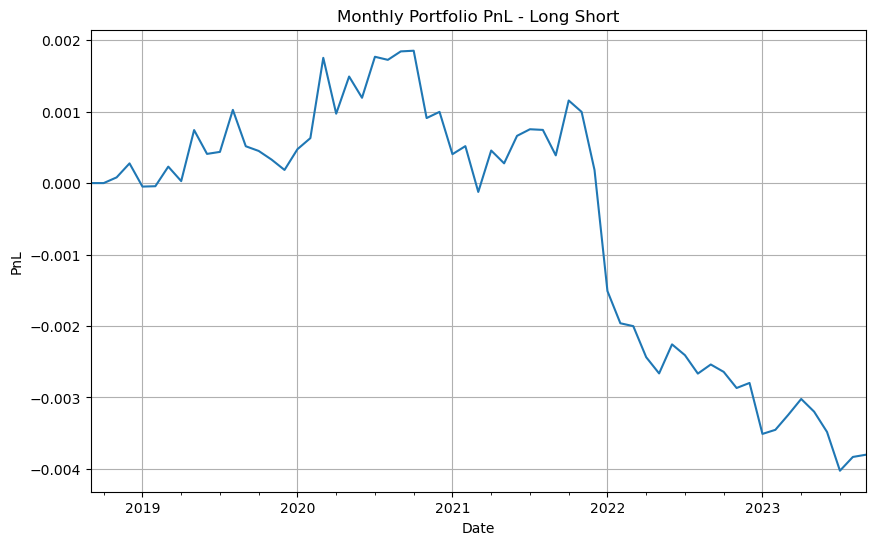

In [66]:
# Plot the PnL
monthly_pnl_long_short.plot(figsize=(10, 6), title='Monthly Portfolio PnL - Long Short')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

### 5.4 Long only and Long-Short

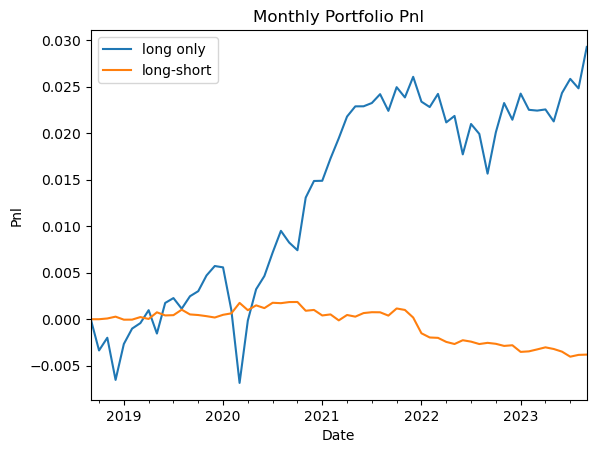

In [67]:
monthly_pnl = pd.concat([monthly_pnl_long_only, monthly_pnl_long_short], axis=1)
monthly_pnl.plot(legend=True)
plt.xlabel('Date')
plt.ylabel('Pnl')
plt.title('Monthly Portfolio Pnl')
plt.legend(['long only', 'long-short'])